# Modelo de Previsão - Acidentes de Trânsito na Paraíba

A previsão de acidentes de trânsito na consiste na aplicação de técnicas de aprendizagem supervisionada para antecipar ocorrências de sinistros viários visando aprimorar a gestão da segurança viária e na implementação de políticas públicas que subsidiem ações estratégicas de redução de sinistros. Nesse contexto, observa-se que os acidentes de trânsito são eventos influenciados por múltiplos fatores, como condições climáticas, infraestrutura viária, tipo do veículo dentre outros. Assim, na construção de um modelo preditivo eficiente, busca-se selecionar variáveis relevantes e algoritmos capazes de identificar padrões em dados históricos, de forma a melhorar a precisão das previsões e subsidiar ações estratégicas de segurança no trânsito.


**Palavras-Chave:** Previsão. Acidentes de Trânsito. Aprendizagem Supervisionada.

**Autores:** Gabriel Batista Pontes e Nercino José de Barros Neto

## Imports

In [ ]:
%pip install pandas
%pip install scikit-learn
%pip install matplotlib

In [2]:
from os import makedirs
import pickle

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

## Carregando o dataset

In [3]:
df = pd.read_csv('data/acidentes_pb.csv')

## Preparando os dados para o modelo

### Selecionando Xs

In [4]:
colunas_uteis = [
    'dia_semana',
    'br',
    'fase_dia',
    'condicao_metereologica',
    'classificacao_acidente',
    'pessoas',
    'veiculos'
]

df = df[colunas_uteis]

### Definindo o target(y)

In [95]:
df.loc[:, 'com_vitima'] = df['classificacao_acidente'].apply(lambda x: False if x.lower() == 'sem vítimas' else True)
df = df.drop(columns=['classificacao_acidente'])

### Criando dummies

In [96]:
df.br = df.br.astype('category')
df = (
    df.pipe(pd.get_dummies, drop_first=True)
    .dropna()
)

numerical_stats = df[['pessoas', 'veiculos']].describe()

categorical_stats = df.select_dtypes(include='bool').sum().sort_values(ascending=False)
print("Estatísticas Descritivas - Variáveis Numéricas:")
print(numerical_stats)

print("\nFrequência de Valores - Variáveis Categóricas:")
print(categorical_stats)

Estatísticas Descritivas - Variáveis Numéricas:
           pessoas     veiculos
count  8307.000000  8307.000000
mean      2.356567     1.791381
std       1.717386     0.878171
min       1.000000     1.000000
25%       1.000000     1.000000
50%       2.000000     2.000000
75%       3.000000     2.000000
max      50.000000    22.000000

Frequência de Valores - Variáveis Categóricas:
com_vitima                                 6823
condicao_metereologica_Céu Claro           5569
br_230                                     5048
fase_dia_Pleno dia                         4538
fase_dia_Plena Noite                       2957
br_101                                     2065
dia_semana_sexta-feira                     1331
dia_semana_sábado                          1274
dia_semana_segunda-feira                   1171
dia_semana_quinta-feira                    1060
dia_semana_quarta-feira                    1057
dia_semana_terça-feira                     1005
condicao_metereologica_Nublado          

### Visualização - Análises Descritivas

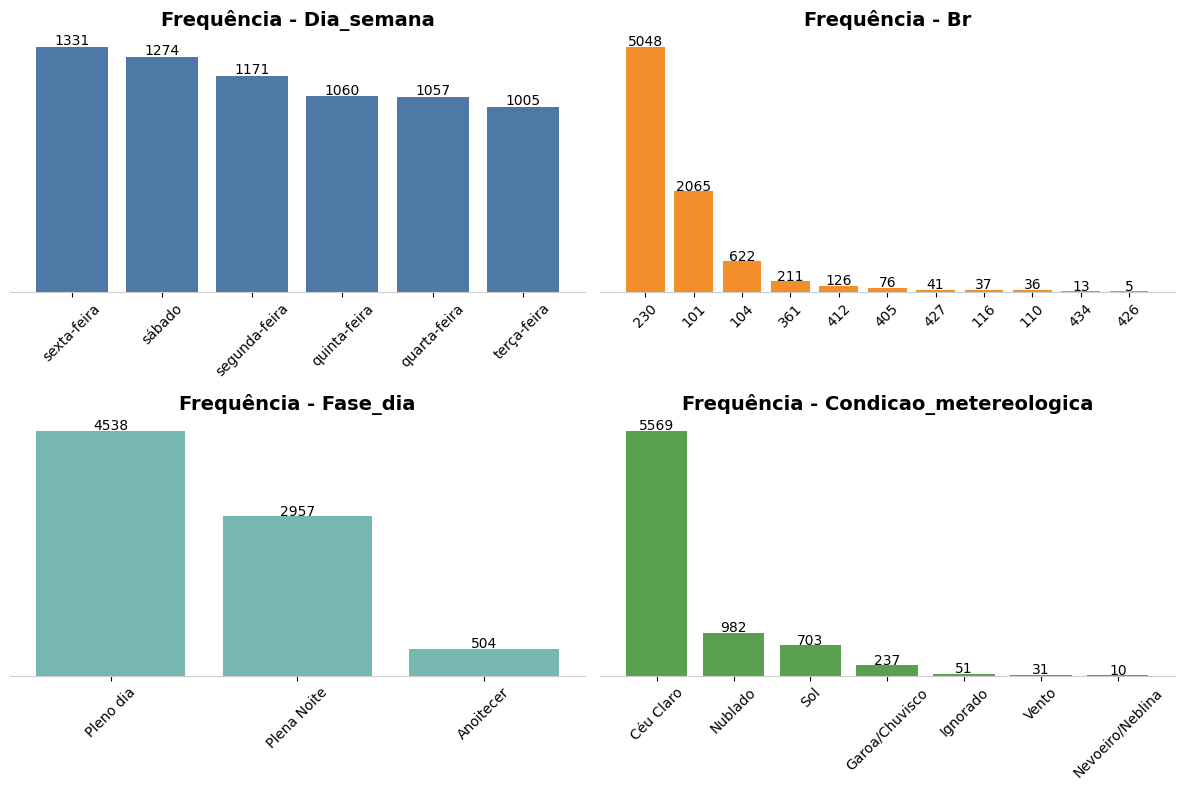

In [97]:
categorias = ['dia_semana', 'br', 'fase_dia', 'condicao_metereologica']
cores = ['#4e79a7', '#f28e2b', '#76b7b2', '#59a14f']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, categoria in enumerate(categorias):
    colunas_categoria = [col for col in categorical_stats.index if col.startswith(categoria)]
    frequencias = categorical_stats[colunas_categoria]

    labels = [col.replace(f"{categoria}_", "") for col in frequencias.index]

    ax = axes[i]
    ax.bar(labels, frequencias.values, color=cores[i % len(cores)])

    for j, freq in enumerate(frequencias.values):
        ax.text(j, freq + 10, f"{freq}", ha='center', fontsize=10, color='black')

    ax.set_title(f'Frequência - {categoria.capitalize()}', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#cccccc')
    ax.get_yaxis().set_visible(False)
    ax.grid(False)

plt.tight_layout()
plt.show()

### Tratando Xs numéricos

In [ ]:
stats = {}

for col in ['pessoas', 'veiculos']:
    if col in df.columns and pd.api.types.is_integer_dtype(df[col]):
        min_val = df[col].min()
        max_val = df[col].max()
        stats[col] = [min_val, max_val]
        df[col] = (df[col] - min_val) / (max_val - min_val)

,pessoas,veiculos
count,8307.000000,8307.000000
mean,0.027685,0.037685
std,0.035049,0.041818
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.020408,0.047619
75%,0.040816,0.047619
max,1.000000,1.000000


## Criando o modelo

#### Separando os dados de treino e teste 70/30

In [99]:
df_treinamento = df.sample(frac=0.7, random_state=21)
df_teste = df.drop(df_treinamento.index)

In [100]:
y = df_treinamento['com_vitima']
X = df_treinamento.drop(['com_vitima'], axis=1)

df_treinamento['com_vitima'].value_counts()/len(df_treinamento['com_vitima'])

com_vitima
True     0.818745
False    0.181255
Name: count, dtype: float64

### Definindo modelos para teste

In [101]:
models = {
    'Logit': LogisticRegression(),
    'NB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Tree': DecisionTreeClassifier(),
    'Forest': RandomForestClassifier()
}

### Gerando os modelos

In [102]:
results = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=30, scoring='accuracy')
    results[name] = {
        'model': model,
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std()
    }

results

{'Logit': {'model': LogisticRegression(),
  'mean_accuracy': 0.8187445471217706,
  'std_accuracy': 0.0017255595744470476},
 'NB': {'model': GaussianNB(),
  'mean_accuracy': 0.21993839360433026,
  'std_accuracy': 0.02114567151148407},
 'KNN': {'model': KNeighborsClassifier(),
  'mean_accuracy': 0.7960445489023021,
  'std_accuracy': 0.016026533906784067},
 'Tree': {'model': DecisionTreeClassifier(),
  'mean_accuracy': 0.7752221213254276,
  'std_accuracy': 0.02392162987476473},
 'Forest': {'model': RandomForestClassifier(),
  'mean_accuracy': 0.7967247119990029,
  'std_accuracy': 0.01980504487983298}}

### Selecionando os 3 melhores modelos pela acurácia

In [103]:
sorted_results = sorted(results.items(), key=lambda item: item[1]['mean_accuracy'], reverse=True)
top_3_model = [item for item in sorted_results[:3]]

for name, item in top_3_model:
    print(f"{name}: {item['mean_accuracy']:.4f} ± {item['std_accuracy']:.4f}")

Logit: 0.8187 ± 0.0017
Forest: 0.7967 ± 0.0198
KNN: 0.7960 ± 0.0160


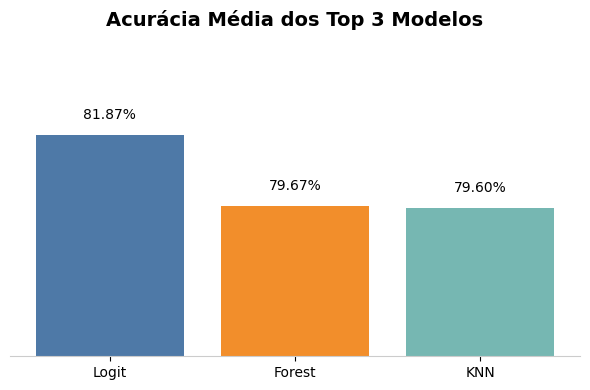

In [104]:
model_names = [name for name, _ in top_3_model]
mean_accuracies = [item['mean_accuracy'] for _, item in top_3_model]

plt.figure(figsize=(6, 4))
colors = ['#4e79a7', '#f28e2b', '#76b7b2']  # Paleta de cores suave
plt.bar(model_names, mean_accuracies, color=colors)

for i, acc in enumerate(mean_accuracies):
    plt.text(i, acc + 0.005, f"{acc:.2%}", ha='center', fontsize=10, color='black')

plt.title('Acurácia Média dos Top 3 Modelos', fontsize=14, fontweight='bold')
plt.ylim(0.75, 0.85)
plt.xticks(fontsize=10)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_color('#cccccc')
plt.gca().axes.get_yaxis().set_visible(False)
plt.grid(False)
plt.tight_layout()
plt.show()


### Testando Top 3 modelos

In [105]:
X_test = df_teste.drop(['com_vitima'], axis=1)
y_test = df_teste['com_vitima']

for name, item in top_3_model:
    model = item['model']
    model.fit(X, y)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\n")

Model: Logit
Accuracy: 0.8270
Confusion Matrix:
[[   0  430]
 [   1 2061]]


Model: Forest
Accuracy: 0.8018
Confusion Matrix:
[[  34  396]
 [  98 1964]]


Model: KNN
Accuracy: 0.8062
Confusion Matrix:
[[  25  405]
 [  78 1984]]




### Salvando os modelos

In [107]:
makedirs('modelos', exist_ok=True)

for name, item in top_3_model:
    filename = f'modelos/modelo_{name}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(item['model'], file)
    print(f"Modelo {name} salvo como {filename}")

Modelo Logit salvo como modelos/modelo_Logit.pkl
Modelo Forest salvo como modelos/modelo_Forest.pkl
Modelo KNN salvo como modelos/modelo_KNN.pkl
